In [1]:
import torch
from torch.autograd import grad
import numpy as np
import scipy.integrate
from numpy import sin, cos
import matplotlib.pyplot as plt
import random
solver = scipy.integrate.solve_ivp

seed = 36
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.determinstic = True


In [2]:
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
import pandas as pd

BATCH_size = 1000

dftarget = pd.read_csv("./data/target.csv", header=None, dtype=np.float32)
dfinput = pd.read_csv("./data/input.csv", header=None, dtype=np.float32)

pmat = np.array([[1.0,0.0,0.0,0.0], [0.0,0.0,1.0,0.0], [0.0,1.0,0.0,0.0], [0.0,0.0,0.0,1.0]], dtype=np.float32)
dftarget = dftarget @ pmat
dfinput = dfinput @ pmat

X_train, X_test, Y_train, Y_test = train_test_split(dfinput.values, dftarget.values, test_size=0.2)

# train data
data_train = data_utils.TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_size, shuffle=True)

# test data
data_test = data_utils.TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))
test_loader = torch.utils.data.DataLoader(data_test, batch_size=BATCH_size, shuffle=True)

In [3]:
import torch.nn as nn
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#!nvidia-smi


In [4]:
class LNN(nn.Module):
    def __init__(self, L):
        super().__init__()
        self.L = L
    def forward(self, x):
        with torch.set_grad_enabled(True):
            self.n = n = x.shape[1]//2
            qqd = x.requires_grad_(True)
            L = self._lagrangian(qqd).sum()
            J = grad(L, qqd, create_graph=True)[0] ;
            DL_q, DL_qd = J[:,:n], J[:,n:]
            DDL_qd = []
            for i in range(n):
                J_qd_i = DL_qd[:,i][:,None]
                H_i = grad(J_qd_i.sum(), qqd, create_graph=True)[0][:,:,None]
                DDL_qd.append(H_i)
            DDL_qd = torch.cat(DDL_qd, 2)
            DDL_qqd, DDL_qdqd = DDL_qd[:,:n,:], DDL_qd[:,n:,:]
            T = torch.einsum('ijk, ij -> ik', DDL_qqd, qqd[:,n:])
            qdd = torch.einsum('ijk, ij -> ik', DDL_qdqd.inverse(), DL_q - T)
        return torch.cat([qqd[:,self.n:], qdd], 1)
    def _lagrangian(self, qqd):
        return self.L(qqd)

    def energy(self, qqd):
        n = qqd.shape[1]//2
        lag = self.L(qqd)
        lag_sum = lag.sum()
        lag_grad = grad(lag_sum, qqd, create_graph=False)[0] ;
        DL_q, DL_qd = lag_grad[:,:n], lag_grad[:,n:]
        dq = qqd[:,n:]
        inner_prod = (dq*DL_qd).sum(1, keepdim=True)
        energy = lag - inner_prod
        return energy    

In [5]:
import time
input_size = 4
hidden_size = 200
output_size = 1

num_trials = 10
stats = {'train_loss': [], 'eval_loss': [], 'computation_time': []}

for trial in range (num_trials):
  l_nn = LNN(nn.Sequential(
          nn.Linear(input_size,hidden_size),
          nn.Tanh(),
          nn.Linear(hidden_size,hidden_size),
          nn.Tanh(),
          nn.Linear(hidden_size,output_size))
       ).to(device)
  
  
  num_epochs = 2000

  criterion = nn.MSELoss()

  optimizer = optim.Adam(params=l_nn.parameters(),lr=0.0001)

  history_loss = []
  history_eval = []
  history_acc = []
  cnt = 0
  startt = time.time()
  for epoch in range(num_epochs):
    l_nn.train()

    total_loss = 0.0
    eval_loss = 0.0
    cnt = 0
    for i,(data,target) in enumerate(train_loader):
      optimizer.zero_grad()
      output = l_nn.forward(data.to(device))

      loss = criterion(output,target.to(device))
      loss.backward()
      optimizer.step()

      total_loss = total_loss+loss.cpu().item()
      cnt = cnt + 1
    total_loss = total_loss/cnt

    num_correct = 0
    num_data = 0
    l_nn.eval()
    eval_loss = 0.0
    cnt = 0
    for i,(data,target) in enumerate(test_loader):
      output = l_nn.forward(data.to(device))
      eval_loss = eval_loss+criterion(output,target.to(device)).cpu().item()
      cnt = cnt + 1
    eval_loss = eval_loss/cnt
  
    history_loss.append(total_loss)
    history_eval.append(eval_loss)

    if total_loss == np.min(history_loss):
      min_total_loss_in_tl = total_loss
      min_evaluation_loss_in_tl = eval_loss
      min_train_index = epoch+1

    if eval_loss == np.min(history_eval):
      min_evalation_loss_in_el = eval_loss
      min_total_loss_in_el = total_loss
      min_evaluation_index = epoch+1
      path = "./model/lnn_dp_min_2t_lr_{}".format(trial)
      torch.save(l_nn.state_dict(), path)
  
    #print("{}/{} training loss:{},evaluation loss:{}".format(epoch+1,num_epochs,total_loss,eval_loss))
  print("{}/{} training loss:{},evaluation loss:{}".format(epoch+1,num_epochs,total_loss,eval_loss))
  print("When the training loss value is smallest: {}/{} min training loss:{}, min evalation loss:{}".format(min_train_index,num_epochs,min_total_loss_in_tl,min_evaluation_loss_in_tl))
  print("When the evaluation loss value is smallest: {}/{} min training loss:{}, min evalation loss:{}".format(min_evaluation_index,num_epochs,min_total_loss_in_el,min_evalation_loss_in_el))

  stats['train_loss'].append(total_loss)
  stats['eval_loss'].append(eval_loss)
  stats['computation_time'].append(time.time() - startt)

print("train_loss:{}, std: {}".format(np.mean(stats['train_loss']), np.std(stats['train_loss'])))
print("test_loss:{}, std: {}".format(np.mean(stats['eval_loss']), np.std(stats['eval_loss'])))
print("computation_time:{}, std: {}".format(np.mean(stats['computation_time']), np.std(stats['computation_time'])))

2000/2000 training loss:0.015370980859734118,evaluation loss:0.015536683262325823
When the training loss value is smallest: 1796/2000 min training loss:0.015332491917070002, min evalation loss:0.015490896999835968
When the evaluation loss value is smallest: 1796/2000 min training loss:0.015332491917070002, min evalation loss:0.015490896999835968
2000/2000 training loss:0.015800679771928117,evaluation loss:0.015948841371573506
When the training loss value is smallest: 1327/2000 min training loss:0.015289386175572873, min evalation loss:0.015441942680627107
When the evaluation loss value is smallest: 1324/2000 min training loss:0.015294847526820376, min evalation loss:0.015438805986195802
2000/2000 training loss:619.4856693115086,evaluation loss:492.34187993705274
When the training loss value is smallest: 696/2000 min training loss:0.01567985978908837, min evalation loss:0.01584119994658977
When the evaluation loss value is smallest: 696/2000 min training loss:0.01567985978908837, min ev

In [7]:
A = pd.read_csv("./data/A.csv", header=None, dtype=np.float32)
B = pd.read_csv("./data/B.csv", header=None, dtype=np.float32)
#A = np.mat(A)@pmat # `np.mat` was removed in the NumPy 2.0 release. Use `np.asmatrix` instead.
#B = np.mat(B)@pmat
A = np.asmatrix(A)
B = np.asmatrix(B)

[0.73424656 0.6566721  0.42773057 0.74193278]
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2297391567699D+01   r2 =  0.1790673223853D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2297391567699D+01   r2 =  0.1790673223853D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2297391567699D+01   r2 =  0.1790673223853D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2297391567699D+01   r2 =  0.51481855

/tmp/ipykernel_51459/1144067866.py:31: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  res = scipy.integrate.odeint(fvec_np,x0,teval)


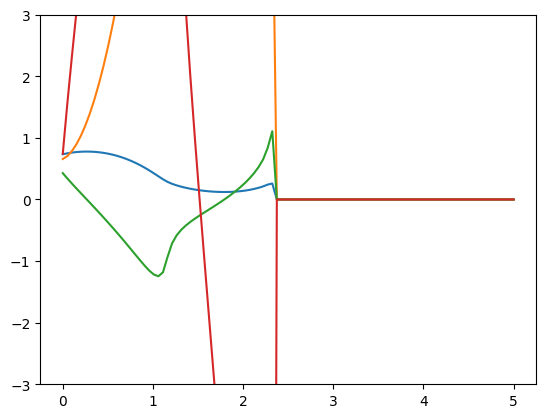

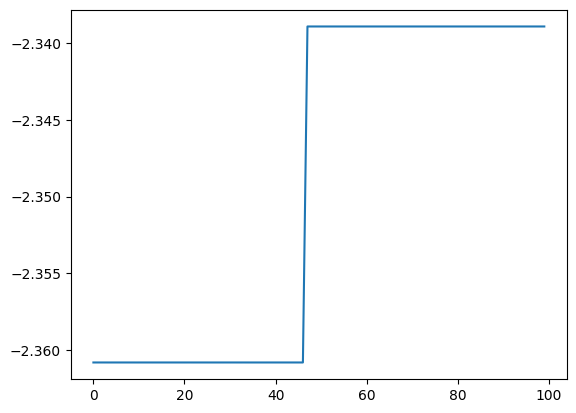

energy error:[0.02192903]
energy_error0:2.041401185326059


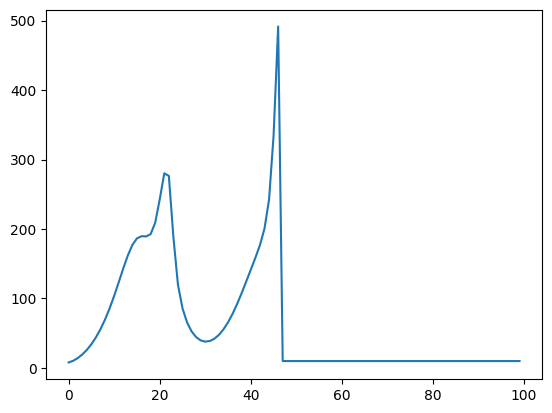

[0.3391952  0.01912268 0.42160305 0.99741402]


/tmp/ipykernel_51459/1144067866.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A, dtype=torch.float32)
/tmp/ipykernel_51459/1144067866.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  B = torch.tensor(B, dtype=torch.float32)


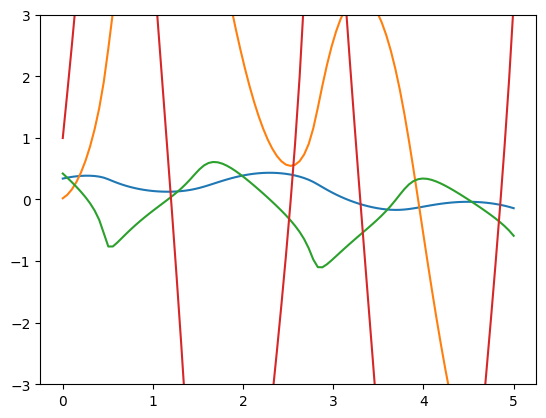

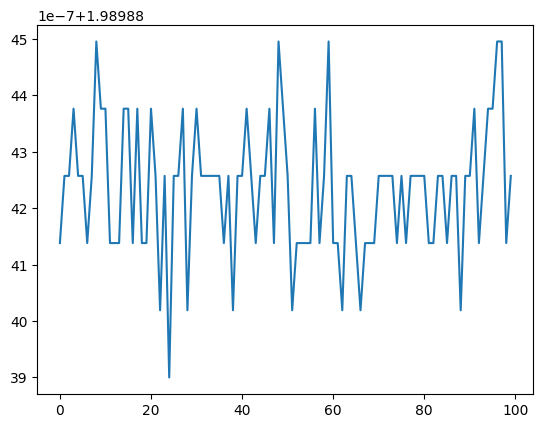

energy error:[1.1920929e-07]
energy_error1:20.394668398346184


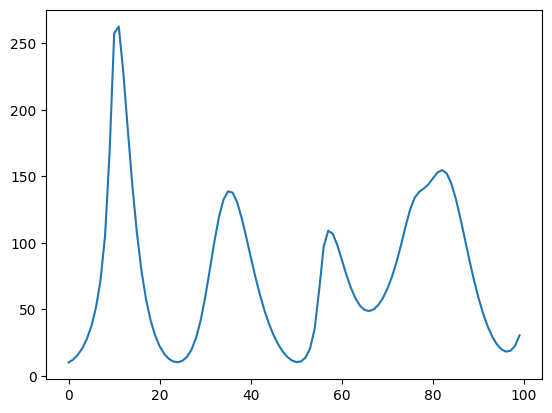

[0.03656911 0.92395591 0.23967218 0.95224603]


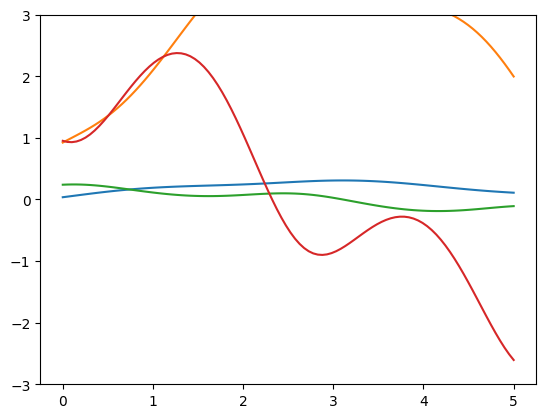

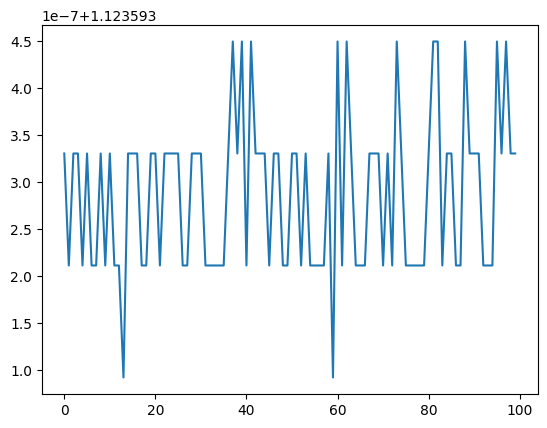

energy error:[0.]
energy_error2:25.097629709757417


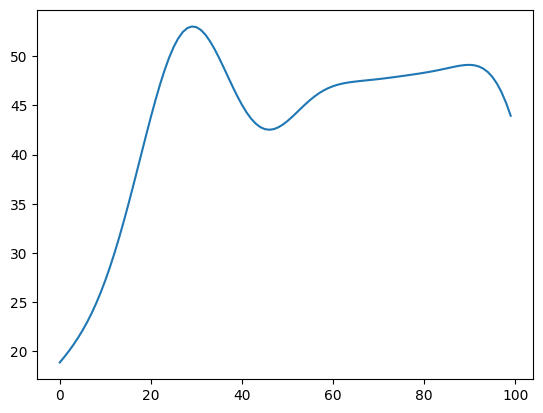

[0.26485681 0.29738391 0.98458253 0.46614086]


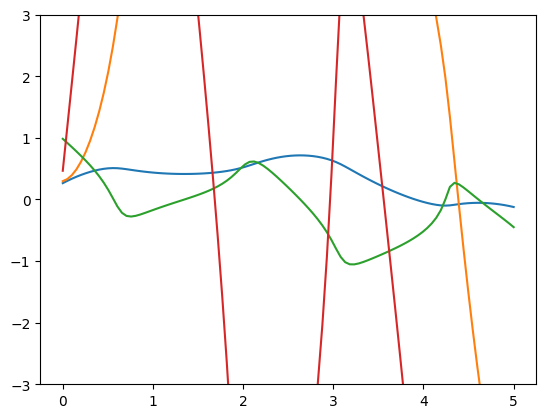

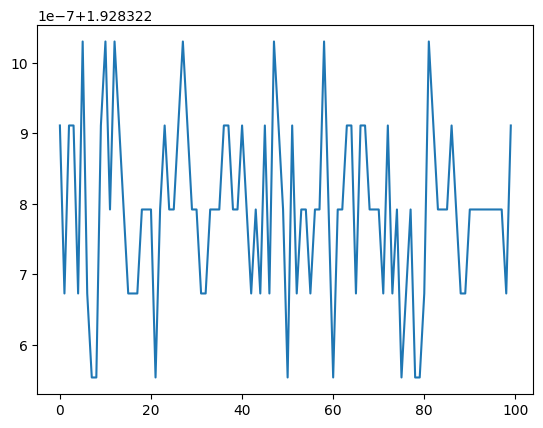

energy error:[0.]
energy_error3:42.792868798859416


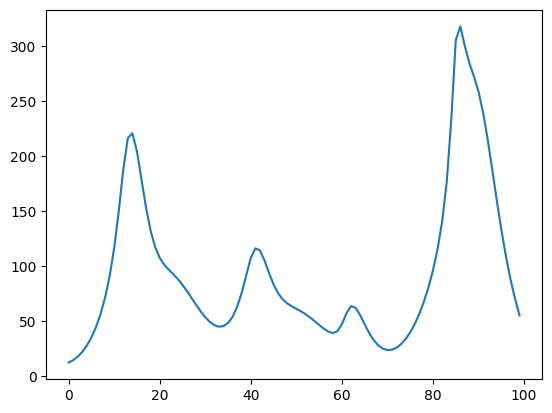

[0.95620719 0.08908681 0.10023305 0.73110729]
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7145165793389D+00   r2 =  0.3250115386653D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7145165793389D+00   r2 =  0.3250115386653D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7145165793389D+00   r2 =  0.3250115386653D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7145165793389D+00   r2 =  0.93440817

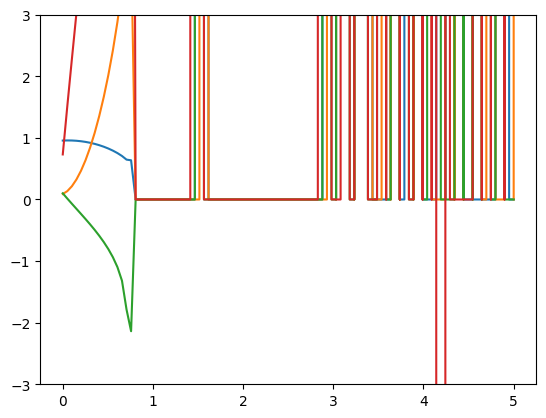

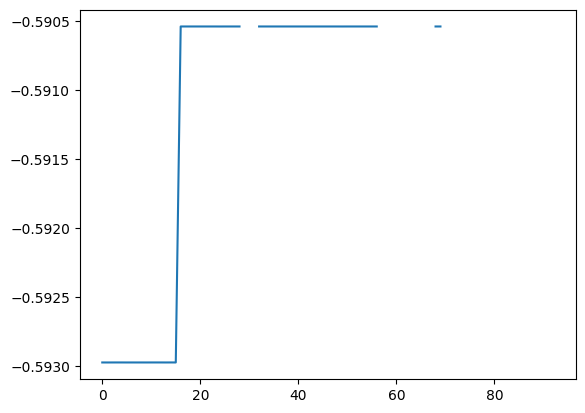

energy error:[nan]
energy_error4:inf


/tmp/ipykernel_51459/1144067866.py:50: RuntimeWarning: overflow encountered in square
  energy = (1/2)*(m1+m2)*np.square(l1)*np.square(res[:,2])+(1/2)*m2*np.square(l2)*np.square(res[:,3])+m2*l1*l2*res[:,2]*res[:,3]*np.cos(res[:,0]-res[:,1])+g*(m1+m2)*l1*np.cos(res[:,0])-g*m2*l2*np.cos(res[:,1])
/tmp/ipykernel_51459/1144067866.py:50: RuntimeWarning: overflow encountered in multiply
  energy = (1/2)*(m1+m2)*np.square(l1)*np.square(res[:,2])+(1/2)*m2*np.square(l2)*np.square(res[:,3])+m2*l1*l2*res[:,2]*res[:,3]*np.cos(res[:,0]-res[:,1])+g*(m1+m2)*l1*np.cos(res[:,0])-g*m2*l2*np.cos(res[:,1])
/tmp/ipykernel_51459/1144067866.py:50: RuntimeWarning: invalid value encountered in add
  energy = (1/2)*(m1+m2)*np.square(l1)*np.square(res[:,2])+(1/2)*m2*np.square(l2)*np.square(res[:,3])+m2*l1*l2*res[:,2]*res[:,3]*np.cos(res[:,0]-res[:,1])+g*(m1+m2)*l1*np.cos(res[:,0])-g*m2*l2*np.cos(res[:,1])


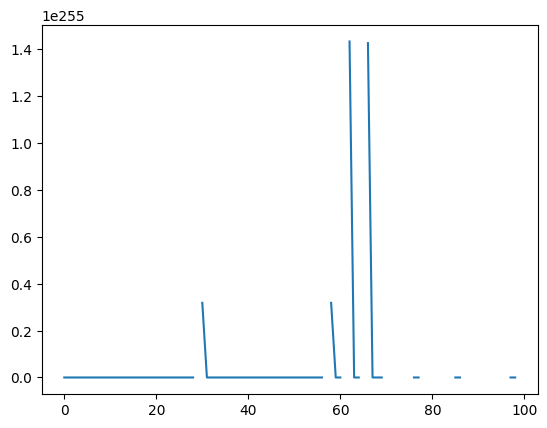

[0.56925707 0.38088485 0.51448741 0.89776162]
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4817223733090D+00   r2 =  0.2057586657927D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4817223733090D+00   r2 =  0.2057586657927D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4817223733090D+00   r2 =  0.2057586657927D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4817223733090D+00   r2 =  0.20575866

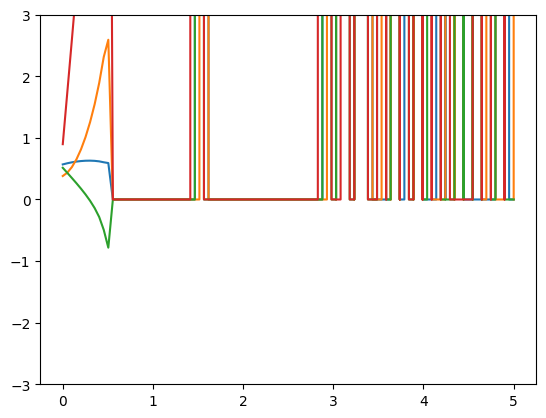

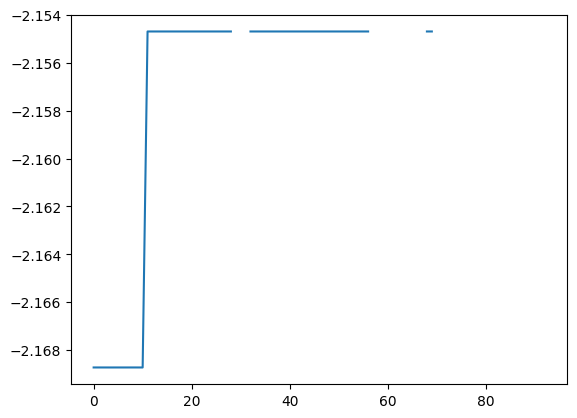

energy error:[nan]
energy_error5:inf


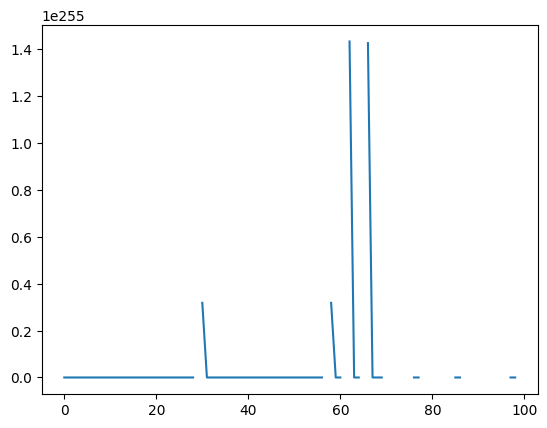

[0.57982002 0.89532277 0.52784278 0.28848429]
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4537599485761D+00   r2 =  0.1250839495440D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4537599485761D+00   r2 =  0.1250839495440D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4537599485761D+00   r2 =  0.1250839495440D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4537599485761D+00   r2 =  0.71923270

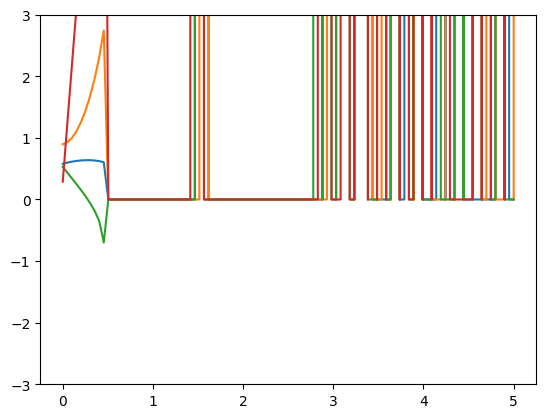

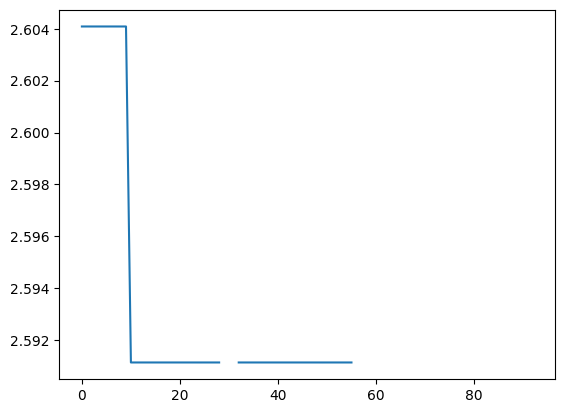

energy error:[nan]
energy_error6:inf


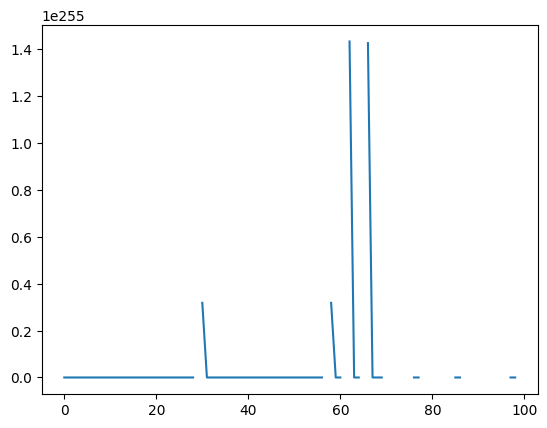

[0.40574935 0.55496527 0.98283737 0.54627115]


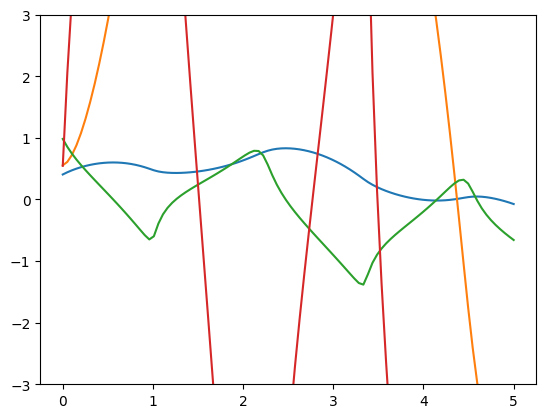

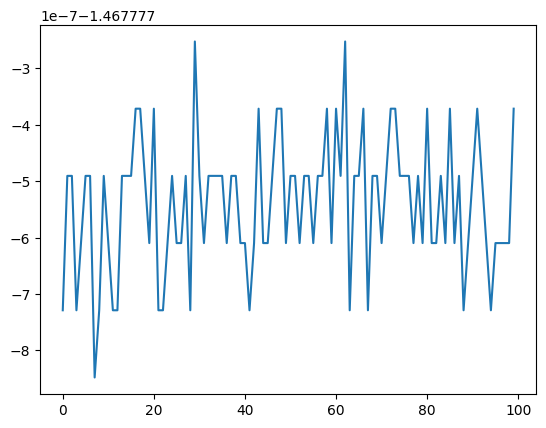

energy error:[3.5762787e-07]
energy_error7:18.732474314685938


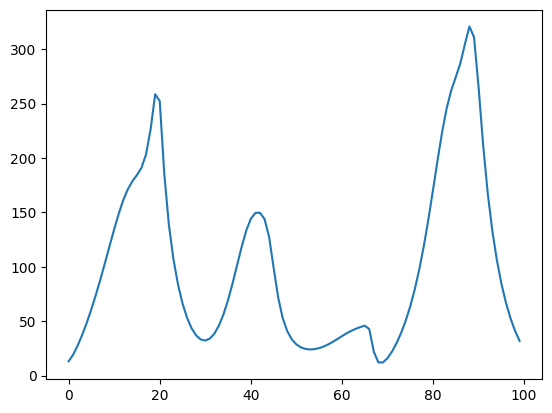

[0.63119862 0.3641424  0.44832169 0.35867564]
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4497426395081D+00   r2 =  0.1195570275821D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4497426395081D+00   r2 =  0.1195570275821D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4497426395081D+00   r2 =  0.1195570275821D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4497426395081D+00   r2 =  0.68745290

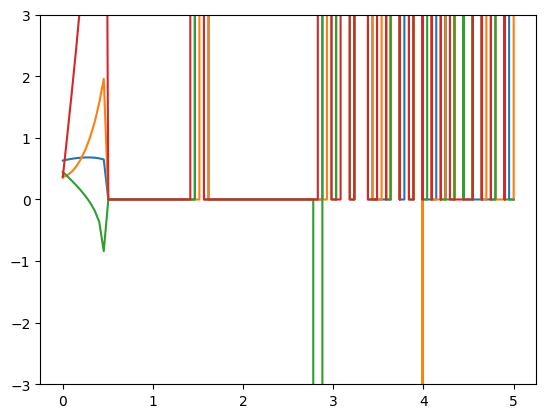

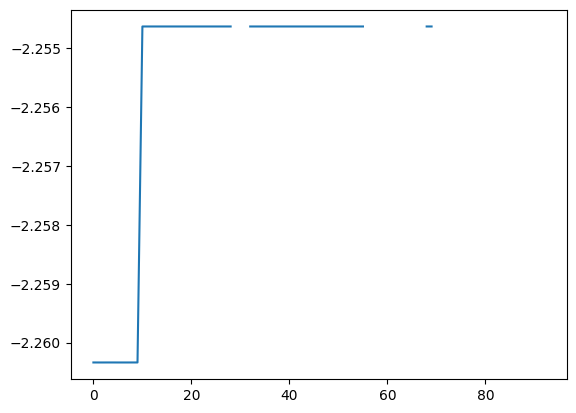

energy error:[nan]
energy_error8:inf


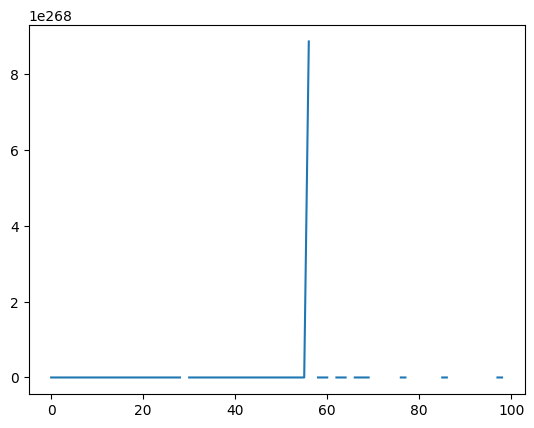

[0.17174863 0.36357341 0.30217936 0.96340619]


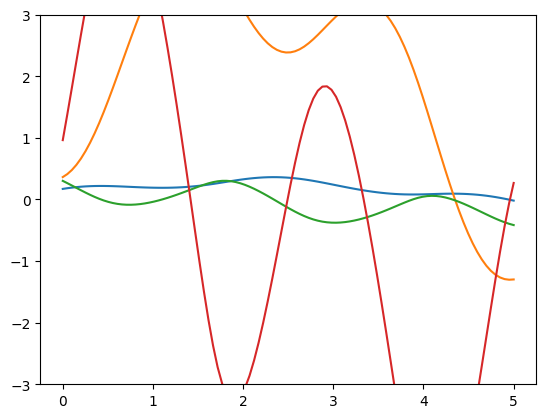

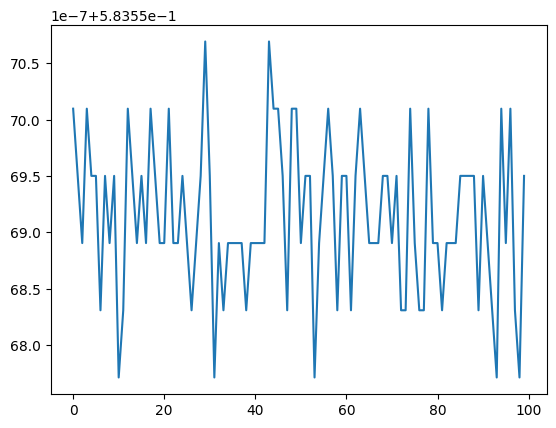

energy error:[-5.9604645e-08]
energy_error9:12.100937134309575


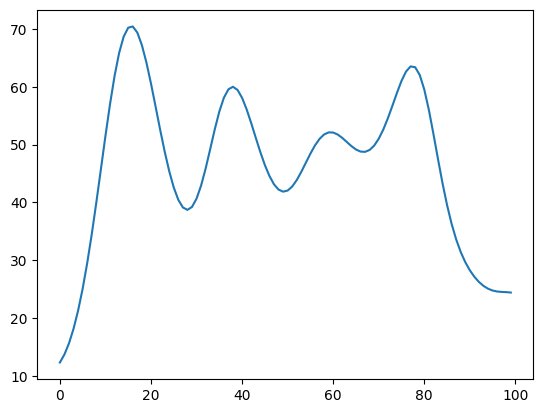

eq_error:[np.float64(2.041401185326059), np.float64(20.394668398346184), np.float64(25.097629709757417), np.float64(42.792868798859416), np.float64(inf), np.float64(inf), np.float64(inf), np.float64(18.732474314685938), np.float64(inf), np.float64(12.100937134309575)] net_error:[array([0.02192903], dtype=float32), array([1.1920929e-07], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([3.5762787e-07], dtype=float32), array([nan], dtype=float32), array([-5.9604645e-08], dtype=float32)]
eq_error:inf, std: nan
net_error:nan, std: nan


/home/danieljh/py-venv/lib/python3.12/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [8]:
# simulation
# parameters
g = 9.8
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1+m2
eq_error = []
net_error = []
for trial in range(num_trials):
  l_nn.load_state_dict(torch.load("./model/lnn_dp_min_2t_lr_{}".format(trial), map_location=device))
  l_nn.eval()
  teval = torch.linspace(0.0,5.0,100)
  x0 = np.random.rand(4)
  #x0 = (0.01825532, 0.52412613, 0.33688556, 0.20706259)
  print(x0)
  dt = teval[1]-teval[0]
  teval = teval.detach().cpu().numpy()
  A = torch.tensor(A, dtype=torch.float32)
  B = torch.tensor(B, dtype=torch.float32)
  l_nn.eval()
  l_nn.cpu()
  def fvec_np(x,t):
      tx = torch.tensor(x, dtype=torch.float).unsqueeze(0)
      x = torch.matmul(tx, torch.inverse(B))
      output = l_nn.forward(x).squeeze(0)
      output = torch.matmul(A, output)
      output = output.squeeze(0)
      return output.detach().cpu().numpy() 
  res = scipy.integrate.odeint(fvec_np,x0,teval)

  ax=plt.subplot()
  ax.set_ylim([-3,3])
  ax.plot(teval,res[:,0])
  ax.plot(teval,res[:,1])
  ax.plot(teval,res[:,2])
  ax.plot(teval,res[:,3])
  plt.show()

  tres = torch.tensor(res, dtype=torch.float, requires_grad=True)
  net_energy = l_nn.energy(torch.matmul(tres, torch.inverse(B)))
  net_energy = net_energy.detach().cpu().numpy()

  plt.plot(net_energy)
  plt.show()
  net_energy_error=net_energy[99]-net_energy[0]
  print("energy error:{}".format(net_energy_error))
    
  energy = (1/2)*(m1+m2)*np.square(l1)*np.square(res[:,2])+(1/2)*m2*np.square(l2)*np.square(res[:,3])+m2*l1*l2*res[:,2]*res[:,3]*np.cos(res[:,0]-res[:,1])+g*(m1+m2)*l1*np.cos(res[:,0])-g*m2*l2*np.cos(res[:,1])
  energy_error=energy[99]-energy[0]
  print("energy_error{}:{}".format(trial,energy_error))
  plt.plot(energy)
  plt.show()

  eq_error.append(energy_error)
  net_error.append(net_energy_error)
print("eq_error:{}".format(eq_error),"net_error:{}".format(net_error))
print("eq_error:{}, std: {}".format(np.mean(np.abs(eq_error)), np.std(eq_error)))
print("net_error:{}, std: {}".format(np.mean(np.abs(net_error)), np.std(net_error)))     

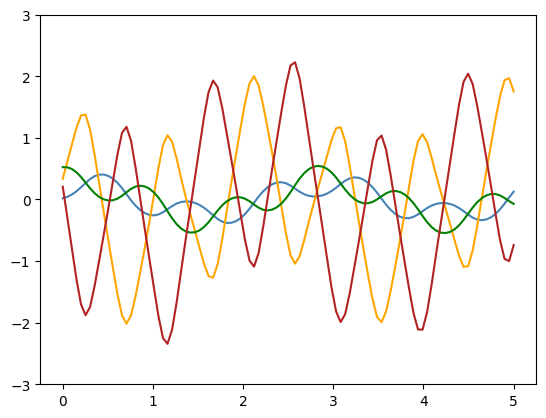

In [9]:
# Ground truth
# parameters
g = 9.8
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1+m2
# equations of motion
def func(t, state):
  cosv = np.cos(state[0]-state[1])
  sinv = np.sin(state[0]-state[1])
  dvdt = np.zeros_like(state)
  dvdt[0] = state[2]
  dvdt[1] = state[3]
  dvdt[2] = (g*(np.sin(state[1])*cosv - m/m2*np.sin(state[0])) - (l1*state[2]*state[2]*cosv + l2* state[3]*state[3])*sinv) / (l1*(m/m2-cosv*cosv))
  dvdt[3] = (g*m/m2*(np.sin(state[0])*cosv - np.sin(state[1])) + sinv * (l1*state[2]*state[2]*m/m2 + l2* state[3]*state[3]*cosv)) / (l2*(m/m2-cosv*cosv))
  return dvdt

#　the time grid
M = 100
tend = 5.0
t_eval = np.linspace(0,tend,M)
dt = t_eval[1]-t_eval[0]

state = []
for i in range(1):
  s = (0.01825532, 0.52412613, 0.33688556, 0.20706259 )
  state.append(s)
p1 = []
v1 = []
p2 = []
v2 = []
flag = False
for i in range(1):
  sol = solver(func, [0, tend], state[i], t_eval=t_eval)
  tval = sol['t']
  q1 = sol['y'][0]
  q2 = sol['y'][1]
  v1 = sol['y'][2]
  v2 = sol['y'][3]
  ax=plt.subplot()
  ax.set_ylim([-3,3])
  ax.plot(tval, q1, 'steelblue')
  ax.plot(tval, v1, 'orange')
  ax.plot(tval, q2, 'g')
  ax.plot(tval, v2, 'firebrick')
  plt.show()